# Wine Quality Analysis and Prediction

## 1. Introduction & Purpose

The goal of this analysis is to understand and predict wine quality.

### Dataset Information
- Dataset: Red wine quality dataset (`Wine_clean.csv`)
- Source: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009?resource=download
- Features: Various chemical properties of wine

### Objectives
We will perform:
1. Clustering: Discover natural groupings among wines.  
2. Regression: Predict numeric quality scores.  
3. Classification: Classify wines into *good* vs *not good* categories.

---

## 2. Data Preparation

### Load & Inspect Data
- Load the dataset
- Check for missing values and general structure

### Principal Component Analysis (PCA)

#### What is PCA?

Principal Component Analysis (PCA) is a statistical technique used to reduce the dimensionality of a dataset while retaining as much information (variance) as possible.  
It transforms the original correlated features into a new set of uncorrelated features called principal components.

Each principal component is a linear combination of the original features that captures the maximum possible variance in the data.

---

#### Why Use PCA in Wine Analysis?

- The wine dataset contains many correlated chemical attributes.  
- PCA helps simplify these into fewer independent variables.
- It makes clustering and visualization (like 2D scatter plots) easier.
- It helps algorithms such as Hierarchical Clustering, KNN, or SVM perform better and faster.

---

#### How PCA Works — Step by Step

1. Standardize the data  
   To give each feature equal weight:
   $$
   X_{scaled} = \frac{X - \mu}{\sigma}
   $$
   where $( \mu\ )$ is the mean and $( \sigma )$ is the standard deviation of each feature.

2. Compute the covariance matrix  
   This measures how features vary together:
   $$
   \Sigma = \frac{1}{n - 1} X_{scaled}^\top X_{scaled}
   $$

3. Find eigenvalues and eigenvectors  
   Solve:
   $$
   \Sigma v_i = \lambda_i v_i
   $$
   - $( v_i )$: eigenvectors → principal component directions  
   - $( \lambda_i )$: eigenvalues → variance explained by each component

4. Sort and select top $( k )$ components  
   Keep the eigenvectors corresponding to the largest eigenvalues (those explain most variance).

5. Project data onto the new axes
   $$
   Z = X_{scaled} W_k$$
   where $( W_k )$ contains the top $( k )$ eigenvectors and $( Z )$ is the transformed (PCA) dataset.

---

#### Explained Variance

Each component explains a fraction of the total variance:

$$
\text{Explained Variance Ratio}_i = \frac{\lambda_i}{\sum_{j=1}^{p} \lambda_j}
$$

A cumulative explained variance plot helps decide how many components to keep.  
For example, if the first 2 components explain 85% of the variance, you can reduce the dataset to 2D while retaining most information.

---

#### Intuitive Example

Imagine each wine is a point in 11-dimensional space (one axis per chemical feature).  
PCA rotates and repositions the coordinate system to find directions where wines differ the most.  
Then we keep only the top few directions (principal components) for visualization or modeling.




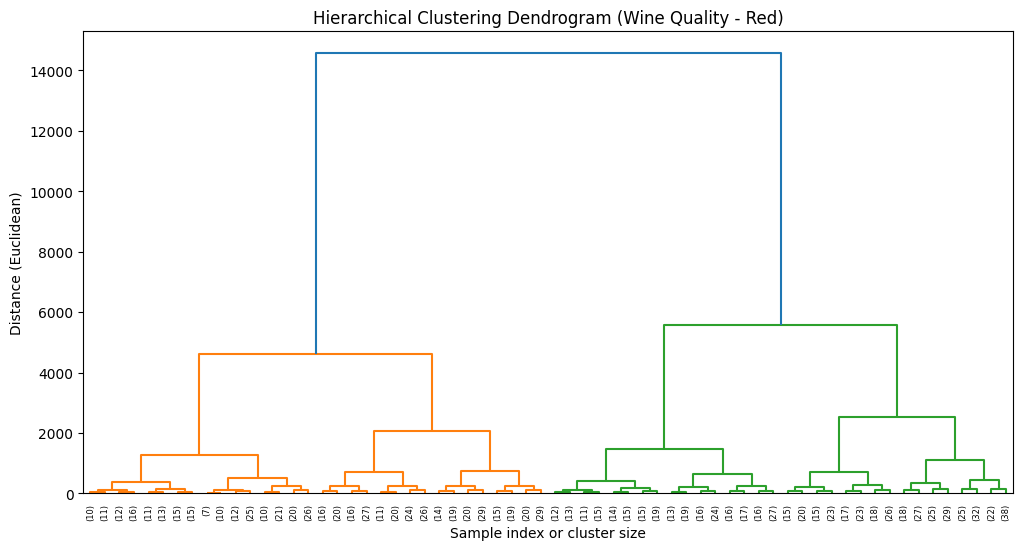

In [ ]:
# --- Import necessary libraries ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import silhouette_score, davies_bouldin_score


# --- Load the dataset ---
df = pd.read_csv('Data/Wine_clean.csv')

# ---  Prepare data for clustering ---
# We drop the 'quality' column because it's a target/label, not an input feature.
X = df.drop('quality', axis=1)


# ---  Compute the linkage matrix for Hierarchical Clustering ---
# The 'ward' method minimizes variance within clusters.
Z = linkage(X, method='ward')

# ---  Plot dendrogram to visualize cluster hierarchy ---
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)  # 'p=5' shows only the last few merges for clarity
plt.title("Hierarchical Clustering Dendrogram (Wine Quality - Red)")
plt.xlabel("Sample index or cluster size")
plt.ylabel("Distance (Euclidean)")
plt.show()

## 3. Clustering

### Agglomerative Hierarchical Clustering

* Perform clustering using `AgglomerativeClustering`
* Set `n_clusters=4`, `linkage='ward'`

### PCA Visualization

* Apply PCA to reduce dimensions to 2D
* Visualize clusters in PCA space using `seaborn`

### Cluster–Quality Analysis

* Compare clusters based on their **average wine quality**
* Identify if certain clusters correspond to higher-quality wines


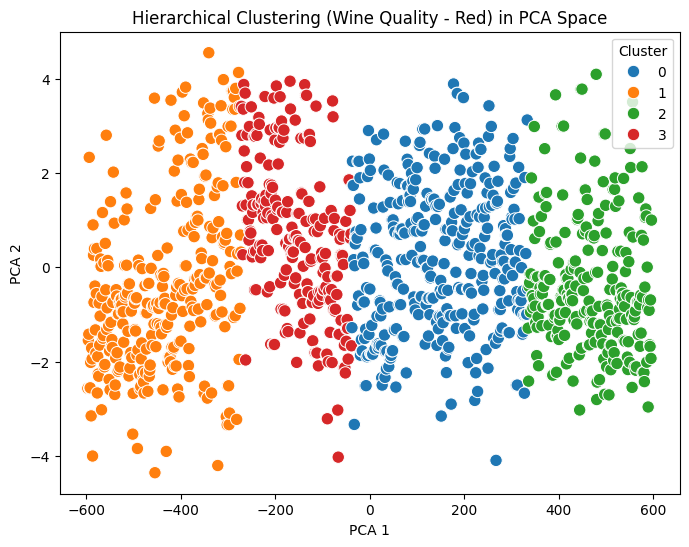

In [ ]:
# --- Apply Agglomerative Clustering (cut the dendrogram into 4 clusters) ---
hac = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = hac.fit_predict(X)

# Add cluster labels back to the DataFrame for later analysis
df['cluster'] = labels

# --- Reduce data to 2D using PCA for visualization ---
# PCA helps us visualize the clusters on a 2D plot even though the data has many features.
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X)

# --- Visualize the clusters in PCA space ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_data[:, 0],
    y=pca_data[:, 1],
    hue=labels,
    palette='tab10',
    s=80
)
plt.title("Hierarchical Clustering (Wine Quality - Red) in PCA Space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.show()

In [ ]:
# --- Analyze clusters by their average wine quality ---
# This tells us whether certain clusters tend to have higher or lower quality scores.
cluster_summary = df.groupby('cluster')['quality'].mean().sort_values(ascending=False)

print("Average wine quality per cluster:")
print(cluster_summary)

Average wine quality per cluster:
cluster
0    5.868633
2    5.572519
1    5.563077
3    5.461538
Name: quality, dtype: float64


In [ ]:
# --- Evaluate clustering performance ---
sil_score = silhouette_score(X, labels)
db_index = davies_bouldin_score(X, labels)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies–Bouldin Index: {db_index:.3f}")


Silhouette Score: 0.540
Davies–Bouldin Index: 0.501


A Silhouette Score of 0.54 means moderate to good clustering — the clusters are fairly well-separated, though not perfectly distinct.

In practical terms:

*   Wines within each cluster are somewhat similar in chemical composition.
*   There’s still some overlap between clusters.

## 4. Regression

### Linear Regression for Quality Prediction

* Split dataset (80% train, 20% test)
* Fit `LinearRegression` model
* Evaluate using:

  * RMSE (Root Mean Squared Error)
  * R² Score


In [ ]:
#Regression

# Linear Regression on wine quality
X_train, X_test, y_train, y_test = train_test_split(X, df['quality'], test_size=0.2, random_state=2)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)  # This returns MSE
rmse = np.sqrt(mse)                        # Take the square root to get RMSE
print("RMSE:", rmse)
print("R²:", r2_score(y_test, y_pred))


RMSE: 0.5527099766632619
R²: 0.42406105255160165


## 5. Classification

### Binary Target

* `is_good_wine = 1` if quality ≥ 7, else 0

### Models Used

* Logistic Regression
* K-Nearest Neighbors (KNN)
* Support Vector Machine (SVM)

### Unified Evaluation Function

Define a helper function to:

* Print metrics: Accuracy, Precision, Recall, F1, ROC-AUC
* Display confusion matrix
* Plot ROC curve

In [ ]:
#Classification

# Create binary target
df['is_good_wine'] = (df['quality'] >= 7).astype(int)
# Then train LogisticRegression, KNN, SVM, etc.
# --- Prepare features and target ---
X = df.drop(['quality', 'is_good_wine'], axis=1)
y = df['is_good_wine']

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

# --- Apply SMOTE to balance the training set ---
sm = SMOTE(random_state=42, sampling_strategy='auto')
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# --- Define models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver='lbfgs'),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights='distance'),
    "SVM": SVC(probability=True, class_weight='balanced', kernel='linear')
}



In [ ]:
# --- Train and evaluate each model ---
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

    if y_proba is not None:
        print("ROC-AUC:", roc_auc_score(y_test, y_proba))

    # Show confusion matrix
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Logistic Regression Results:
Accuracy: 0.899581589958159
Precision: 0.6666666666666666
Recall: 0.3448275862068966
F1 Score: 0.45454545454545453
ROC-AUC: 0.860919540229885
Confusion Matrix:
 [[205   5]
 [ 19  10]]

KNN Results:
Accuracy: 0.8744769874476988
Precision: 0.47058823529411764
Recall: 0.27586206896551724
F1 Score: 0.34782608695652173
ROC-AUC: 0.7233169129720853
Confusion Matrix:
 [[201   9]
 [ 21   8]]

SVM Results:
Accuracy: 0.7447698744769874
Precision: 0.3
Recall: 0.8275862068965517
F1 Score: 0.44036697247706424
ROC-AUC: 0.8594417077175698
Confusion Matrix:
 [[154  56]
 [  5  24]]
